#  **Diabetic Retinopathy Detection 12,000 Images**

In this notebook, we work with a dataset of approximately 12,000 images. The dataset was carefully balanced to ensure an equal number of images with and without diabetes. This balance improves the performance of the binary classification by providing a more evenly distributed dataset.

# **1. Imports**

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import shutil
import glob
import cv2
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
import torchvision.models as models
import tensorflow as tf
import torch.nn.functional as F
from PIL import Image
from skimage.io import imread
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from tensorflow.image import resize
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from concurrent.futures import ThreadPoolExecutor
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **2. Loading Data and EDA**

We create a dataframe containing:
- the image name;
- the path to the image;
- a variable specifying if the eye is the right one (0) or the left one (1);
- the label specifying the level of the retinopathy desease (0 to 4);
- the patient ID.

In [ ]:
base_image_dir = os.path.join('..', '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/DATA_12K')
retina_df = pd.read_csv(os.path.join('/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/', 'testLabels.csv'))

retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, '{}.jpeg'.format(x)))

retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

retina_df = retina_df[retina_df['exists']]
retina_df

12534 images found of 53576 total


,image,level,Usage,PatientId,path,exists,eye
16,9_left,4,Private,9,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
17,9_right,4,Private,9,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0
26,24_left,0,Private,24,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
29,26_right,0,Private,26,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0
34,29_left,1,Private,29,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
...,...,...,...,...,...,...,...
53555,44333_right,3,Private,44333,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0
53558,44336_left,0,Private,44336,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
53565,44342_right,0,Private,44342,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0
53568,44345_left,0,Private,44345,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1


In [ ]:
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

def one_hot_encode(category, max_value):
    one_hot = [0] * (max_value + 1)
    one_hot[category] = 1
    return one_hot

max_level = retina_df['level'].max()
retina_df = retina_df[retina_df['exists']]

12534 images found of 12534 total


In [ ]:
retina_df

,image,level,Usage,PatientId,path,exists,eye,level_cat
16,9_left,4,Private,9,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 0, 0, 0, 1]"
17,9_right,4,Private,9,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[0, 0, 0, 0, 1]"
26,24_left,0,Private,24,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]"
29,26_right,0,Private,26,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[1, 0, 0, 0, 0]"
34,29_left,1,Private,29,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
53555,44333_right,3,Private,44333,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[0, 0, 0, 1, 0]"
53558,44336_left,0,Private,44336,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]"
53565,44342_right,0,Private,44342,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[1, 0, 0, 0, 0]"
53568,44345_left,0,Private,44345,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]"


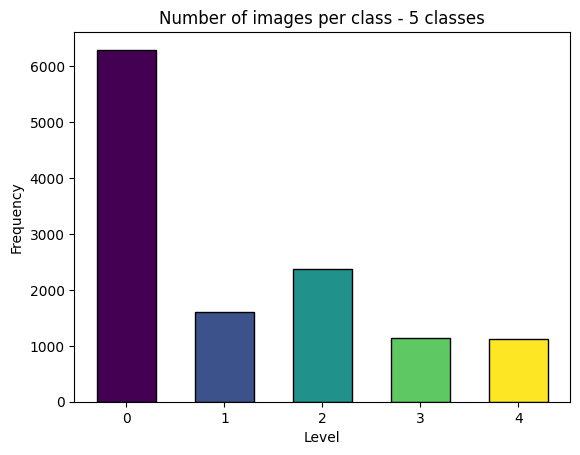

In [ ]:
bins = range(int(retina_df["level"].min()), int(retina_df["level"].max()) + 2)

counts, bins, patches = plt.hist(retina_df["level"], bins=bins, edgecolor='black', rwidth=0.6)

bin_centers = [0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)]
plt.xticks(bin_centers, [str(int(bin_center - 0.5)) for bin_center in bin_centers])

colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.xlabel('Level')
plt.ylabel('Frequency')
plt.title('Number of images per class - 5 classes')

plt.show()

We decided to add a binary label:
- 0 indicates that the patient is healthy
- 1 indicates the presence of diabetic retinopathy (DR)

In [ ]:
retina_df['binary_level'] = retina_df['level'].apply(lambda x: 0 if x == 0 else 1)

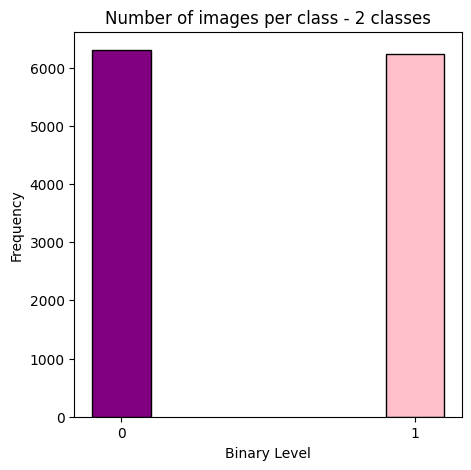

In [ ]:
bins = [0, 1, 2]

fig, ax = plt.subplots(figsize=(5, 5))
counts, bins, patches = ax.hist(retina_df['binary_level'], bins=bins, edgecolor='black', rwidth=0.2, align='mid')

ax.set_xticks([0.5, 1.5])
ax.set_xticklabels([0, 1])

colors = ['purple', 'pink']
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

ax.set_xlabel('Binary Level')
ax.set_ylabel('Frequency')
ax.set_title('Number of images per class - 2 classes')

plt.show()

In [ ]:
retina_df

,image,level,Usage,PatientId,path,exists,eye,level_cat,binary_level
16,9_left,4,Private,9,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 0, 0, 0, 1]",1
17,9_right,4,Private,9,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[0, 0, 0, 0, 1]",1
26,24_left,0,Private,24,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]",0
29,26_right,0,Private,26,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[1, 0, 0, 0, 0]",0
34,29_left,1,Private,29,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 1, 0, 0, 0]",1
...,...,...,...,...,...,...,...,...,...
53555,44333_right,3,Private,44333,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[0, 0, 0, 1, 0]",1
53558,44336_left,0,Private,44336,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]",0
53565,44342_right,0,Private,44342,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[1, 0, 0, 0, 0]",0
53568,44345_left,0,Private,44345,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]",0


# **3. Preprocessing**

We preprocessed the images using OpenCV package to:  

1. rescale the images to have the same radius (300 pixels),  

2. subtracted the local average color that gets mapped to 50% gray,  

3. clipped the images to 90% size to remove the boundary effects (the black background around the eye).


First we tried to preprocess one image, then we make a loop to preprocess all images.

In [ ]:
def scaleRadius(img, scale):
    x = img[img.shape[0] // 2, :, :].sum(1)
    r = (x > x.mean() / 10).sum() / 2
    s = scale * 1.0 / r
    return cv2.resize(img, (0, 0), fx=s, fy=s)

scale = 300

for f in glob.glob(base_image_dir):
    try:
        a = cv2.imread(f)
        a = scaleRadius(a, scale)

        a = cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0, 0), scale/30), -4, 128)

        b = np.zeros(a.shape)
        cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(scale * 0.9), (1, 1, 1), -1, 8, 0)
        a = a * b + 128 * (1 - b) # a = a * b black

        output_file_path = os.path.join(output_path, os.path.basename(f))

        cv2.imwrite(output_file_path, a)
    except Exception as e:
        print(f, e)

# **4. Models' Setup**

We define a function set_seed to set the random seed. This ensures that our experiments are reproducible.

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

We define a series of transformations to be applied to the images. These transformations include resizing the images to 224x224 pixels, converting the images to PyTorch tensors, and normalizing the images with specific mean and standard deviation values calculated for our dataset.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0079, 0.0078, 0.0119], std=[0.9779, 0.9835, 0.9530])
])

These functions handle the image loading and transformation, returning the processed image tensors along with their labels.

In [ ]:
def load_binary(row):
    image_path = row['path']
    if os.path.exists(image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        return image_tensor, row['binary_level']
    return None

def load_5(row):
    image_path = row['path']
    if os.path.exists(image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        return image_tensor, row['level']
    return None

These functions utilize multithreading to efficiently load and transform the images, returning lists of image tensors and labels.

In [ ]:
def create_tensors_binary(df):
    image_tensors = []
    labels = []
    with ThreadPoolExecutor() as executor:
        results = executor.map(load_binary, [row for _, row in df.iterrows()])
        for result in results:
            if result is not None:
                image_tensor, label = result
                image_tensors.append(image_tensor)
                labels.append(label)
    return image_tensors, labels

def create_tensors_5(df):
    image_tensors = []
    labels = []
    with ThreadPoolExecutor() as executor:
        results = executor.map(load_5, [row for _, row in df.iterrows()])
        for result in results:
            if result is not None:
                image_tensor, label = result
                image_tensors.append(image_tensor)
                labels.append(label)
    return image_tensors, labels

Next, we create tensors for binary classification and 5-class classification. Both sections print the shapes of the resulting tensors to verify the data processing.

In [ ]:
image_tensors_bin, labels_bin = create_tensors_binary(retina_df)

images_tensor_bin = torch.stack(image_tensors_bin)
labels_tensor_bin = torch.tensor(labels_bin, dtype=torch.float32)
print(f"Total images binary: {images_tensor_bin.shape}")
print(f"Total labels binary: {labels_tensor_bin.shape}")

Total images binary: torch.Size([12534, 3, 224, 224])
Total labels binary: torch.Size([12534])


In [ ]:
image_tensors_5, labels_5 = create_tensors_5(retina_df)

images_tensor_5 = torch.stack(image_tensors_5)
labels_tensor_5 = torch.tensor(labels_5, dtype=torch.long)
print(f"Total images 5 classes: {images_tensor_5.shape}")
print(f"Total labels 5 classes: {labels_tensor_5.shape}")

Total images 5 classes: torch.Size([12534, 3, 224, 224])
Total labels 5 classes: torch.Size([12534])


In [ ]:
class RetinaDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

This custom dataset class is essential for using the DataLoader in PyTorch, allowing for easy batching and shuffling of the data.

These next cells split the binary and 5-classes image tensors and labels into training and testing sets, create datasets and DataLoaders for each, and print the shape of the first batch from the training DataLoader.

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images_tensor_bin, labels_tensor_bin, test_size=0.3, random_state=42)

train_dataset = RetinaDataset(train_images, train_labels)
test_dataset = RetinaDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([10, 3, 224, 224])
Batch of labels shape: torch.Size([10])


In [ ]:
train_images_5, test_images_5, train_labels_5, test_labels_5 = train_test_split(images_tensor_5, labels_tensor_5, test_size=0.3, random_state=42)

train_dataset_5 = RetinaDataset(train_images_5, train_labels_5)
test_dataset_5 = RetinaDataset(test_images_5, test_labels_5)

train_loader_5 = DataLoader(train_dataset_5, batch_size=10, shuffle=True)
test_loader_5 = DataLoader(test_dataset_5, batch_size=10, shuffle=False)

for images, labels in train_loader_5:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([10, 3, 224, 224])
Batch of labels shape: torch.Size([10])


# **5. VGG16 model - Binary Classification**

In this section, we utilize a pre-trained VGG16 model to perform binary classification. The model is modified to include a custom classifier head, which consists of a linear layer followed by a ReLU activation, dropout for regularization, and another linear layer leading into a Sigmoid activation function. The model is trained using Binary Cross Entropy Loss (BCELoss) and optimized with Stochastic Gradient Descent (SGD).

In [ ]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False

vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

vgg16 = vgg16.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We implement early stopping to prevent overfitting, using a patience of 3 epochs. The learning rate is adjusted dynamically using a ReduceLROnPlateau scheduler, which reduces the learning rate when the validation loss stops improving.

Training and validation losses are recorded and visualized to monitor the learning process.

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

patience = 3
early_stopping_counter = 0
previous_val_loss = float('inf')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(12):
    vgg16.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = vgg16(images)
        outputs = outputs.squeeze(dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}, \n Loss: {train_loss}, Accuracy: {train_accuracy}")

    vgg16.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = vgg16(images)
            outputs = outputs.squeeze(dim=1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_loss / len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    scheduler.step(val_loss)

    if val_loss < previous_val_loss:
        previous_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, 
 Loss: 0.6296090240970016, Accuracy: 0.6478969565712983
Validation Loss: 0.6168594764450849, Validation Accuracy: 0.6540813613400691
Epoch 2, 
 Loss: 0.6270300930616253, Accuracy: 0.6470990539154223
Validation Loss: 0.6149324888395051, Validation Accuracy: 0.6514224940175485
Epoch 3, 
 Loss: 0.620838647754969, Accuracy: 0.6530263307876439
Validation Loss: 0.614694520578546, Validation Accuracy: 0.6532837011433129
Epoch 4, 
 Loss: 0.6180713306391158, Accuracy: 0.6534822751624302
Validation Loss: 0.6099912056983527, Validation Accuracy: 0.6588673225206062
Epoch 5, 
 Loss: 0.612071779906614, Accuracy: 0.6618032600022797
Validation Loss: 0.6082911205998922, Validation Accuracy: 0.6644509438978995
Epoch 6, 
 Loss: 0.6111111005169927, Accuracy: 0.6643109540636042
Validation Loss: 0.6076280302920584, Validation Accuracy: 0.6615261898431268
Epoch 7, 
 Loss: 0.608516573838058, Accuracy: 0.6681864812492876
Validation Loss: 0.6049752730434224, Validation Accuracy: 0.6673756979526722
Epo

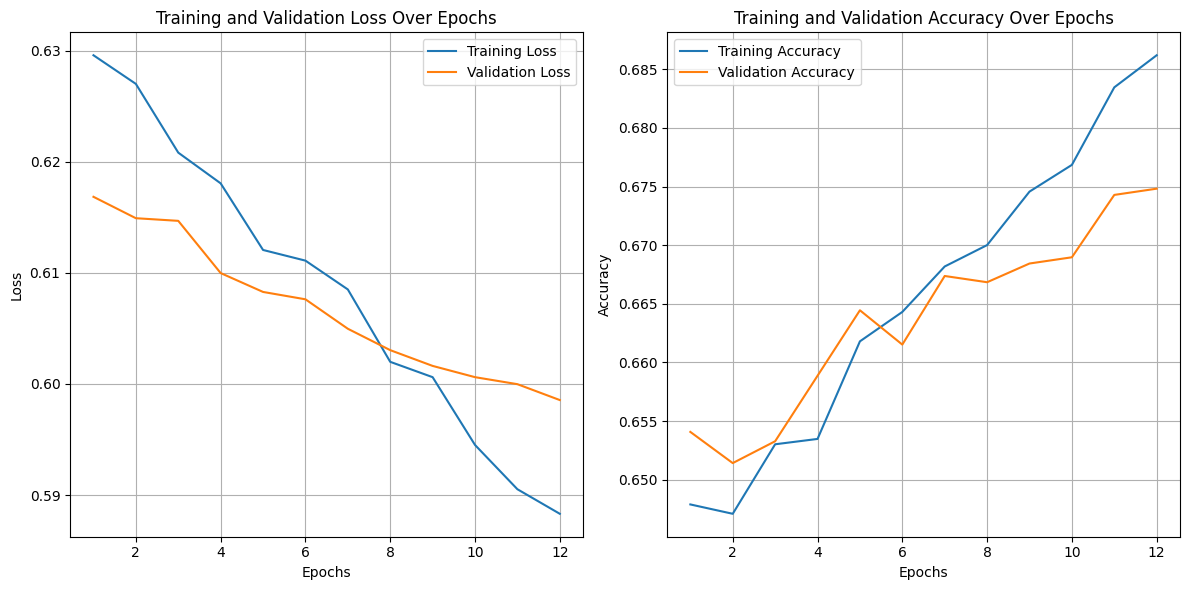

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The training and validation loss graphs indicate a good learning process, with both losses decreasing over epochs and no significant signs of overfitting. Training validation accuracies increase over epochs as we would hope.

Additionally, we evaluate the model's performance on both training and test sets by calculating accuracy and plotting a confusion matrix to visualize classification performance.

In [ ]:
vgg16.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = vgg16(images).squeeze()
        predicted = outputs.round()
        if predicted.dim() == 0:
            predicted = predicted.unsqueeze(0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    final_train_acc = correct / total
    print("Training accuracy:", final_train_acc * 100)

with torch.no_grad():
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = vgg16(images).squeeze()
        predicted = outputs.round()
        if predicted.dim() == 0:
            predicted = predicted.unsqueeze(0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
    test_acc = correct / total
    print("Test accuracy:", test_acc * 100)

Training accuracy: 70.95634332611421
Test accuracy: 67.48205264557299


The training and test accuracies are reasonably close, suggesting that the model generalizes adequately from the training data to the test data.

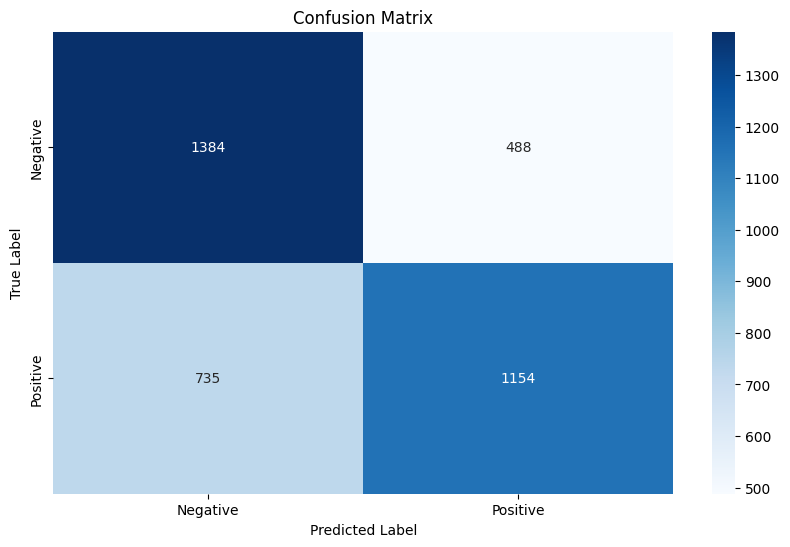

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix for this binary classification shows that the model has improved its performance. This is because the dataset is now balanced for classes with and without diabetes.

In [ ]:
model_save_path = '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/vgg16_binary_classification.pth'
torch.save(vgg16.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/vgg16_binary_classification.pth


# **6. VGG16 model - 5 Classes**

In this section, we adapt the VGG16 model for multi-class classification, where the task is to classify images into one of five distinct classes. Similar to the binary classifier, the VGG16 model is pre-trained, and its classifier head is replaced with a custom architecture. This custom head includes a linear layer followed by a ReLU activation, dropout for regularization, and a final linear layer with a Softmax activation to output probabilities for each of the five classes. The model is trained using Cross Entropy Loss and optimized with SGD.




In [ ]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16_5 = models.vgg16(pretrained=True)
for param in vgg16_5.features.parameters():
    param.requires_grad = False

vgg16_5.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5),
    nn.Softmax(dim=1)
)

vgg16_5 = vgg16_5.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Early stopping is also implemented here to avoid overfitting, with a patience of 3 epochs. A ReduceLROnPlateau scheduler dynamically adjusts the learning rate based on validation loss improvements.


We record and plot training and validation losses to assess the model's learning trajectory.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Loss: 1.4313261060888511
Validation Loss: 1.4090486183090614
Epoch 2, Loss: 1.4013877101666834
Validation Loss: 1.4084485127375677
Epoch 3, Loss: 1.4006359924080702
Validation Loss: 1.4083190052831838
Epoch 4, Loss: 1.4003051083560414
Validation Loss: 1.4082617620574385
Epoch 5, Loss: 1.4002859217023524
Validation Loss: 1.4082281877254617
Epoch 6, Loss: 1.4006692709439437
Validation Loss: 1.4082094294955307
Epoch 7, Loss: 1.400040980623632
Validation Loss: 1.40819382509439
Epoch 8, Loss: 1.4003201391132112
Validation Loss: 1.4081925526854213
Epoch 9, Loss: 1.3998115863778324
Validation Loss: 1.408191470315665
Epoch 10, Loss: 1.4000168005534892
Validation Loss: 1.4081902447050383
Epoch 11, Loss: 1.4003507217948148
Validation Loss: 1.408190184942291
Epoch 12, Loss: 1.3998259567997178
Validation Loss: 1.4081901264443637


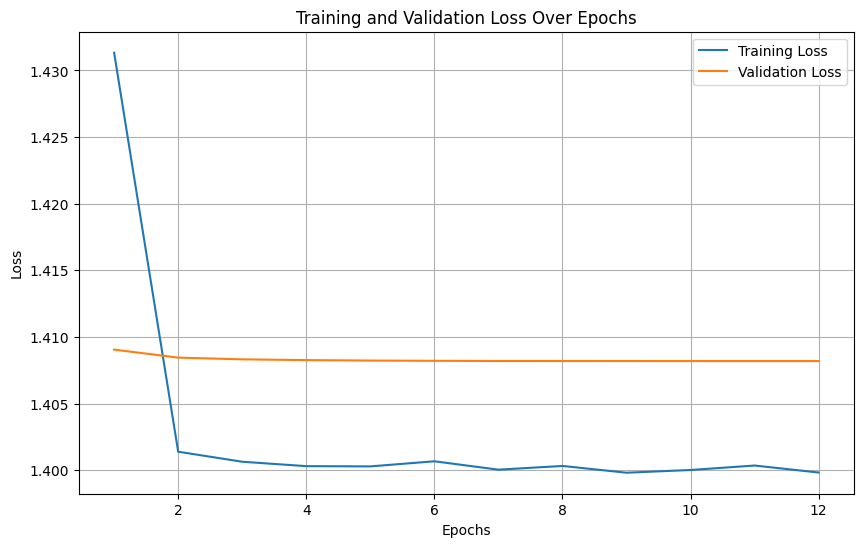

In [ ]:
criterion_5 = nn.CrossEntropyLoss()
optimizer_5 = optim.SGD(vgg16_5.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

scheduler_5 = ReduceLROnPlateau(optimizer_5, mode='min', factor=0.1, patience=3, verbose=True)

patience_5 = 3
early_stopping_counter_5 = 0
previous_val_loss_5 = float('inf')

train_losses_5 = []
val_losses_5 = []

for epoch in range(12):
    vgg16_5.train()
    running_loss_5 = 0.0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        optimizer_5.zero_grad()
        outputs = vgg16_5(images)
        outputs = outputs.squeeze(dim=1)
        loss = criterion_5(outputs, labels)
        loss.backward()
        optimizer_5.step()
        running_loss_5 += loss.item()

    train_loss_5 = running_loss_5 / len(train_loader_5)
    train_losses_5.append(train_loss_5)
    print(f"Epoch {epoch+1}, Loss: {train_loss_5}")

    vgg16_5.eval()
    val_loss_5 = 0.0
    with torch.no_grad():
        for images, labels in test_loader_5:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16_5(images)
            outputs = outputs.squeeze(dim=1)
            loss = criterion_5(outputs, labels)
            val_loss_5 += loss.item()

    val_loss_5 /= len(test_loader_5)
    val_losses_5.append(val_loss_5)
    print(f"Validation Loss: {val_loss_5}")

    scheduler_5.step(val_loss_5)

    if val_loss_5 < previous_val_loss_5:
        previous_val_loss_5 = val_loss_5
        early_stopping_counter_5 = 0
    else:
        early_stopping_counter_5 += 1
        if early_stopping_counter_5 >= patience_5:
            print("Early stopping triggered")
            break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_5) + 1), train_losses_5, label='Training Loss')
plt.plot(range(1, len(val_losses_5) + 1), val_losses_5, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

The training and validation loss graphs show that the model quickly reaches its optimal performance but does not improve significantly with more epochs. Both losses stabilize early, indicating that the model's learning capacity is limited.

Performance evaluation is done by calculating accuracy on the training and test sets and generating a confusion matrix to provide insights into the classification accuracy across different classes.

In [ ]:
vgg16_5.eval()
with torch.no_grad():
    correct_5, total_5 = 0, 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16_5(images)
        _, predicted = torch.max(outputs, 1)
        total_5 += labels.size(0)
        correct_5 += (predicted == labels).sum().item()
    final_train_acc_5 = correct_5 / total_5
    print("Training accuracy:", final_train_acc_5 * 100)

with torch.no_grad():
    correct_5, total_5 = 0, 0
    all_preds_5 = []
    all_labels_5 = []
    for images, labels in test_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16_5(images)
        _, predicted = torch.max(outputs, 1)
        total_5 += labels.size(0)
        correct_5 += (predicted == labels).sum().item()
        all_preds_5.extend(predicted.cpu().numpy())
        all_labels_5.extend(labels.cpu().numpy())
    test_acc_5 = correct_5 / total_5
    print("Test accuracy:", test_acc_5 * 100)

Training accuracy: 50.473042288840766
Test accuracy: 49.773996277585745


The training and test accuracies are low, suggesting that the model has poor generalization and struggles to classify instances correctly across multiple classes.

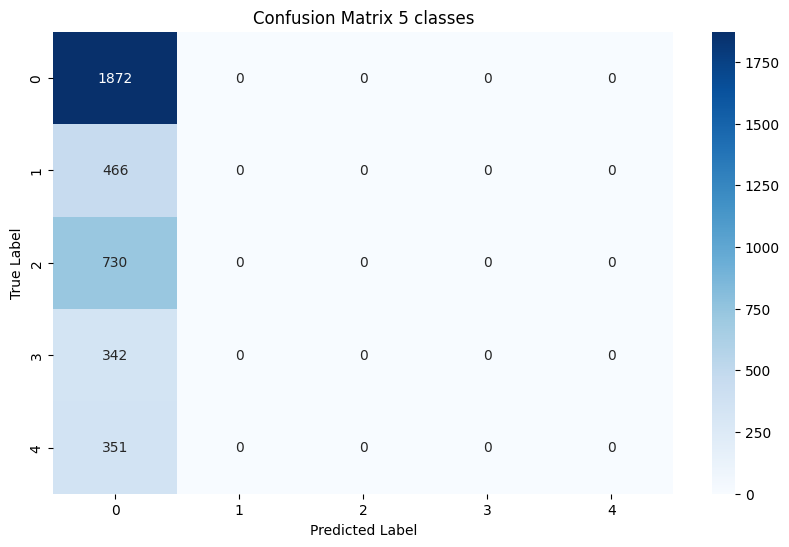

In [ ]:
cm_5 = confusion_matrix(all_labels_5, all_preds_5)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_5, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix 5 classes')
plt.show()

The confusion matrix indicates the same issue with class imbalance. The model fails to predict any instances for classes 1 through 4.

# **7. AlexNet - Binary Classification**

In this section, we utilize a pre-trained AlexNet model to perform binary classification. The model is modified to include a custom classifier head, which consists of a linear layer followed by a ReLU activation, dropout for regularization, and another linear layer followed by a Sigmoid function to ensure binary classification.

In [ ]:
set_seed(42)

alexnet = models.alexnet(pretrained=True)
for param in alexnet.features.parameters():
    param.requires_grad = False

alexnet.classifier[6] = nn.Sequential(
    nn.Linear(alexnet.classifier[6].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1)
    nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 226MB/s]


The model is trained using Binary Cross Entropy Loss (BCELoss) and optimized with Stochastic Gradient Descent (SGD). A scheduler is also used, to prevent overfitting, using a patience of 3 epochs. The learning rate is adjusted dynamically using a ReduceLROnPlateau scheduler, which reduces the learning rate when the validation loss stops improving.

In [ ]:
criterion_a = nn.nn.BCELoss()
optimizer_a = optim.SGD(alexnet.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler_a = ReduceLROnPlateau(optimizer_a, 'min', patience=3, verbose=True)

best_test_loss_a = float('inf')
patience_a = 3
trigger_times_a = 0

num_epochs = 12
train_losses_a = []
train_accuracies_a = []
test_losses_a = []
test_accuracies_a = []

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer_a.zero_grad()
        outputs = alexnet(images)
        loss = criterion_a(outputs, labels)
        loss.backward()
        optimizer_a.step()

        running_loss += loss.item() * images.size(0)

        preds = torch.sigmoid(outputs).round()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses_a.append(epoch_loss)
    train_accuracies_a.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, \n Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    scheduler_a.step(epoch_loss)

    alexnet.eval()
    test_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = alexnet(images)
            loss = criterion_a(outputs, labels)
            test_running_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs).round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss = test_running_loss / len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses_a.append(test_loss)
    test_accuracies_a.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    if test_loss < best_test_loss_a:
        best_test_loss_a = test_loss
        trigger_times_a = 0
    else:
        trigger_times_a += 1
        if trigger_times_a >= patience_a:
            print(f"Early stopping at epoch {epoch+1}")
            break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/12, 
 Loss: 0.6775, Accuracy: 0.5680
Test Loss: 0.6532, Test Accuracy: 0.6123
Epoch 2/12, 
 Loss: 0.6643, Accuracy: 0.5987
Test Loss: 0.6443, Test Accuracy: 0.6325
Epoch 3/12, 
 Loss: 0.6563, Accuracy: 0.6102
Test Loss: 0.6411, Test Accuracy: 0.6275
Epoch 4/12, 
 Loss: 0.6530, Accuracy: 0.6143
Test Loss: 0.6306, Test Accuracy: 0.6490
Epoch 5/12, 
 Loss: 0.6489, Accuracy: 0.6234
Test Loss: 0.6365, Test Accuracy: 0.6395
Epoch 6/12, 
 Loss: 0.6465, Accuracy: 0.6228
Test Loss: 0.6263, Test Accuracy: 0.6589
Epoch 7/12, 
 Loss: 0.6460, Accuracy: 0.6294
Test Loss: 0.6252, Test Accuracy: 0.6557
Epoch 8/12, 
 Loss: 0.6422, Accuracy: 0.6321
Test Loss: 0.6219, Test Accuracy: 0.6631
Epoch 9/12, 
 Loss: 0.6382, Accuracy: 0.6306
Test Loss: 0.6197, Test Accuracy: 0.6602
Epoch 10/12, 
 Loss: 0.6356, Accuracy: 0.6373
Test Loss: 0.6235, Test Accuracy: 0.6525
Epoch 11/12, 
 Loss: 0.6356, Accuracy: 0.6253
Test Loss: 0.6168, Test Accuracy: 0.6634
Epoch 12/12, 
 Loss: 0.6334, Accuracy: 0.6429
Test L

Additionally, we evaluate the model's performance on both training and test sets by calculating accuracy and plotting a confusion matrix to visualize classification performance.

In [ ]:
alexnet.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = alexnet(images)
        predicted = torch.sigmoid(outputs).round()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    final_train_acc_a = correct / total
    print("Training accuracy:", final_train_acc_a * 100)

all_preds_a = []
all_labels_a = []
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = alexnet(images)
        predicted = torch.sigmoid(outputs).round()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_preds_a.extend(predicted.cpu().numpy().tolist())
        all_labels_a.extend(labels.cpu().numpy().tolist())
    test_acc = correct / total
    print("Test accuracy:", test_acc * 100)


Training accuracy: 66.32850792203351
Test accuracy: 65.91332092528582


Training and test accuracy are reasonably close, indicating that we are avoiding overfitting.

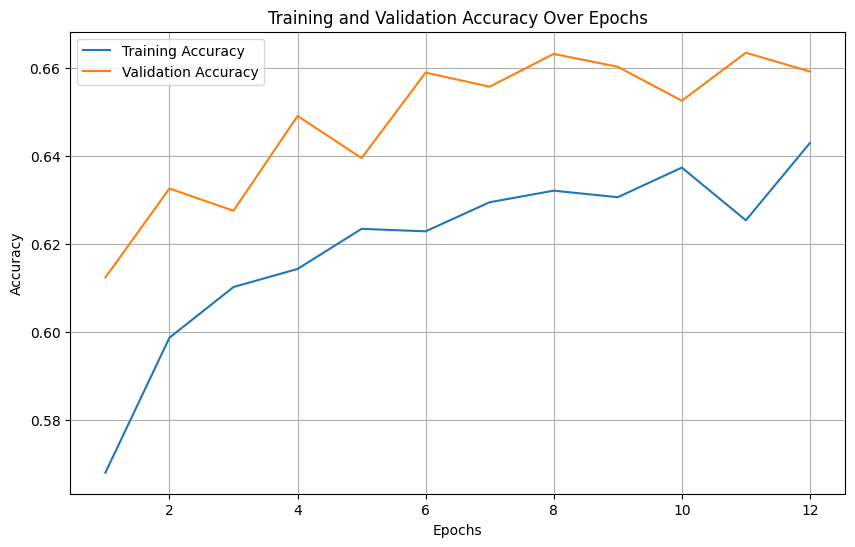

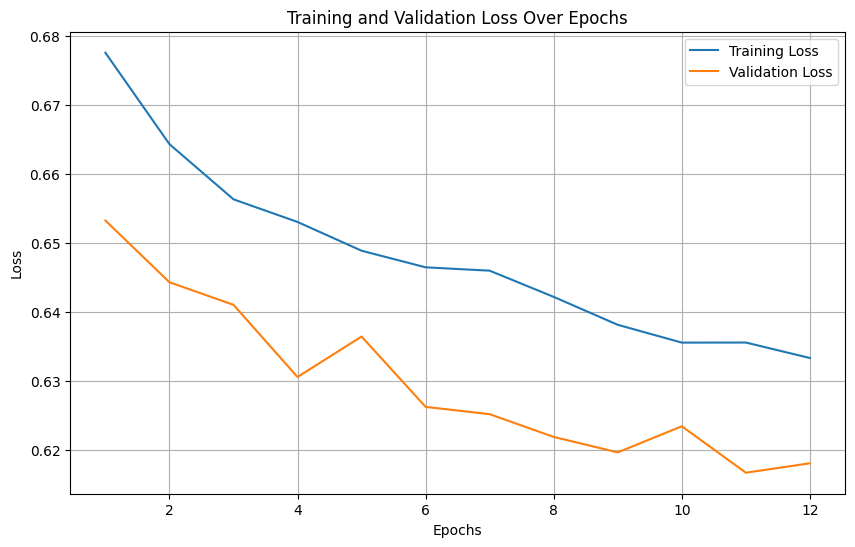

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies_a) + 1), train_accuracies_a, label='Training Accuracy')
plt.plot(range(1, len(test_accuracies_a) + 1), test_accuracies_a, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_a) + 1), train_losses_a, label='Training Loss')
plt.plot(range(1, len(test_losses_a) + 1), test_losses_a, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


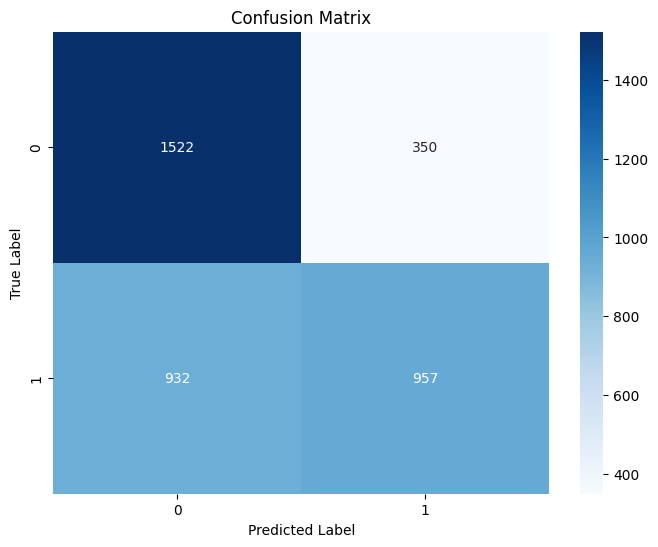

In [ ]:
cm_a = confusion_matrix(all_labels_a, all_preds_a)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_a, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Visualizing the results, we see that our model doesn't perform too bad, with an accuracy of 65.9\% and improves comparedparing to the model trained on the unbalanced dataset.

In [ ]:
model_save_path = '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/alex_binary_classification.pth'
torch.save(alexnet.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/alex_binary_classification.pth


# **8. AlexNet - 5 Classes**

Here, we adapt the pre-trained AlexNet model for multi-class classification, where the task is to classify images into one of five distinct classes.
We modified the final fully connected layer of AlexNet to output probabilities for five classes. The feature extraction layers of AlexNet were frozen, and the classifier was adapted to include additional fully connected layers, ReLU activation, and dropout for regularization.

In [ ]:
set_seed(42)

alexnet = models.alexnet(pretrained=True)
for param in alexnet.features.parameters():
    param.requires_grad = False

alexnet.classifier[6] = nn.Sequential(
    nn.Linear(alexnet.classifier[6].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The model was trained using Cross Entropy Loss and optimized with Adam. A learning rate scheduler and early stopping were employed to enhance training efficiency and prevent overfitting.

In [ ]:
criterion_a_5 = nn.CrossEntropyLoss()
optimizer_a_5 = optim.Adam(alexnet.parameters(), lr=0.0001)
scheduler_a_5 = ReduceLROnPlateau(optimizer_a_5, 'min', patience=3, verbose=True)

num_epochs = 10
train_losses_a_5 = []
train_accuracies_a_5 = []
test_losses_a_5 = []
test_accuracies_a_5 = []

best_test_loss_a_5 = float('inf')
patience_a_5 = 3
trigger_times_a_5 = 0

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)

        optimizer_a_5.zero_grad()

        outputs = alexnet(images)
        loss = criterion_a_5(outputs, labels)

        loss.backward()
        optimizer_a_5.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader_5.dataset)
    epoch_accuracy = correct / total
    train_losses_a_5.append(epoch_loss)
    train_accuracies_a_5.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    scheduler_a_5.step(epoch_loss)

    alexnet.eval()
    test_running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader_5:
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet(images)
            loss = criterion_a_5(outputs, labels)
            test_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    test_loss = test_running_loss / len(test_loader_5.dataset)
    test_accuracy = correct / total
    test_losses_a_5.append(test_loss)
    test_accuracies_a_5.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    if test_loss < best_test_loss_a_5:
        best_test_loss_a_5 = test_loss
        trigger_times_a_5 = 0
    else:
        trigger_times_a_5 += 1
        if trigger_times_a_5 >= patience_a_5:
            print(f"Early stopping at epoch {epoch+1}")
            break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10, Loss: 1.2766, Accuracy: 0.5225
Test Loss: 1.2507, Test Accuracy: 0.5387
Epoch 2/10, Loss: 1.2052, Accuracy: 0.5395
Test Loss: 1.2161, Test Accuracy: 0.5451
Epoch 3/10, Loss: 1.1715, Accuracy: 0.5506
Test Loss: 1.2382, Test Accuracy: 0.5286
Epoch 4/10, Loss: 1.1298, Accuracy: 0.5614
Test Loss: 1.2016, Test Accuracy: 0.5456
Epoch 5/10, Loss: 1.1046, Accuracy: 0.5705
Test Loss: 1.1744, Test Accuracy: 0.5491
Epoch 6/10, Loss: 1.0712, Accuracy: 0.5810
Test Loss: 1.1765, Test Accuracy: 0.5525
Epoch 7/10, Loss: 1.0424, Accuracy: 0.5867
Test Loss: 1.2048, Test Accuracy: 0.5413
Epoch 8/10, Loss: 1.0027, Accuracy: 0.5981
Test Loss: 1.2371, Test Accuracy: 0.5363
Early stopping at epoch 8


In [ ]:
alexnet.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    final_train_acc_a_5 = correct / total
    print("Training accuracy:", final_train_acc_a_5 * 100)

all_preds_a_5 = []
all_labels_a_5 = []
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in test_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds_a_5.extend(preds.cpu().numpy().tolist())
        all_labels_a_5.extend(labels.cpu().numpy().tolist())
    test_acc_a_5 = correct / total
    print("Test accuracy:", test_acc_a_5 * 100)

Training accuracy: 65.53060526615752
Test accuracy: 53.62935389524063


Training and test accuracy are low and have a pretty high gap, indicating that the model doesn't generalize well.

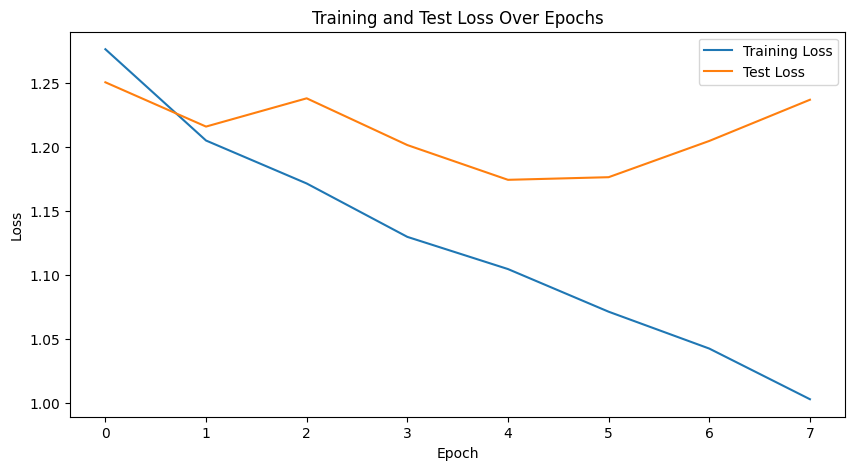

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_a_5, label='Training Loss')
plt.plot(test_losses_a_5, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

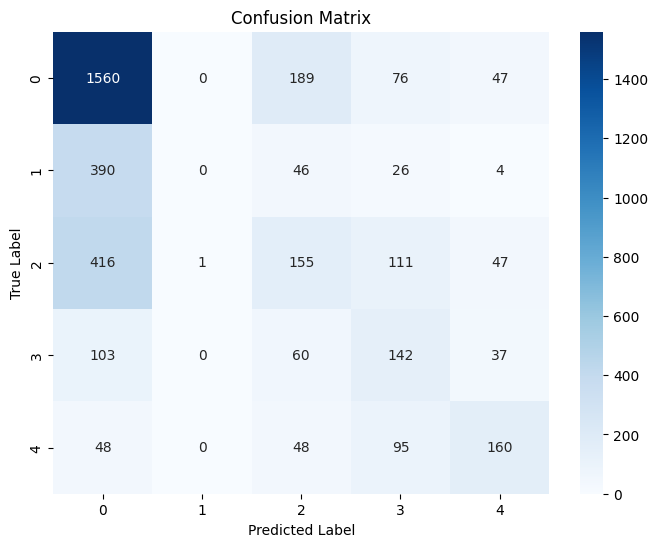

In [ ]:
cm_a_5 = confusion_matrix(all_labels_a_5, all_preds_a_5)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_a_5, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Despite the measures employed, with a test accuracy of 53.6 \%, satisfactory results were not achieved on this dataset. In fact, almost all the classes end up being misclassified as zeros.


# **9. GoogleLeNet - Binary Classification**

In this section, we utilize a pre-trained GoogleNet model to perform binary classification. The model is adapted to include a custom classifier head, replacing the original fully connected layer with a new one tailored for binary output. We employ Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss) and optimize the model using Stochastic Gradient Descent (SGD).

In [ ]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

googlenet = models.googlenet(pretrained=True)

for param in googlenet.parameters():
    param.requires_grad = False

num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, 1)
googlenet.aux_logits = False

googlenet = googlenet.to(device)

criterion_g = nn.BCEWithLogitsLoss()
optimizer_g = optim.SGD(googlenet.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler_g = ReduceLROnPlateau(optimizer_g, mode='min', factor=0.1, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 136MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.w

We implement early stopping to avoid overfitting, with a patience of 3 epochs. A ReduceLROnPlateau scheduler is used to dynamically adjust the learning rate when the validation loss plateaus.

In [ ]:
patience = 3
early_stopping_counter = 0
previous_val_loss = float('inf')

train_losses_g = []
val_losses_g = []
train_accuracies_g = []
val_accuracies_g = []
num_epochs = 12

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer_g.zero_grad()
        outputs = googlenet(images)
        outputs = outputs.squeeze(dim=1)
        loss = criterion_g(outputs, labels)
        loss.backward()
        optimizer_g.step()

        running_loss += loss.item() * images.size(0)

        preds = torch.sigmoid(outputs).round()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_train / total_train
    train_losses_g.append(epoch_loss)
    train_accuracies_g.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    googlenet.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = googlenet(images).squeeze(dim=1)
            loss = criterion_g(outputs, labels)
            val_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs).round()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses_g.append(val_loss)
    val_accuracies_g.append(val_accuracy)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    scheduler_g.step(val_loss)

    if val_loss < previous_val_loss:
        previous_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1/12, Loss: 0.6790, Accuracy: 0.5674
Validation Loss: 0.6620, Validation Accuracy: 0.6235
Epoch 2/12, Loss: 0.6625, Accuracy: 0.6023
Validation Loss: 0.6502, Validation Accuracy: 0.6193
Epoch 3/12, Loss: 0.6524, Accuracy: 0.6195
Validation Loss: 0.6393, Validation Accuracy: 0.6405
Epoch 4/12, Loss: 0.6448, Accuracy: 0.6307
Validation Loss: 0.6315, Validation Accuracy: 0.6567
Epoch 5/12, Loss: 0.6422, Accuracy: 0.6308
Validation Loss: 0.6273, Validation Accuracy: 0.6551
Epoch 6/12, Loss: 0.6397, Accuracy: 0.6381
Validation Loss: 0.6250, Validation Accuracy: 0.6533
Epoch 7/12, Loss: 0.6351, Accuracy: 0.6340
Validation Loss: 0.6209, Validation Accuracy: 0.6658
Epoch 8/12, Loss: 0.6338, Accuracy: 0.6367
Validation Loss: 0.6225, Validation Accuracy: 0.6573
Epoch 9/12, Loss: 0.6318, Accuracy: 0.6376
Validation Loss: 0.6149, Validation Accuracy: 0.6719
Epoch 10/12, Loss: 0.6293, Accuracy: 0.6452
Validation Loss: 0.6169, Validation Accuracy: 0.6652
Epoch 11/12, Loss: 0.6276, Accuracy: 0.

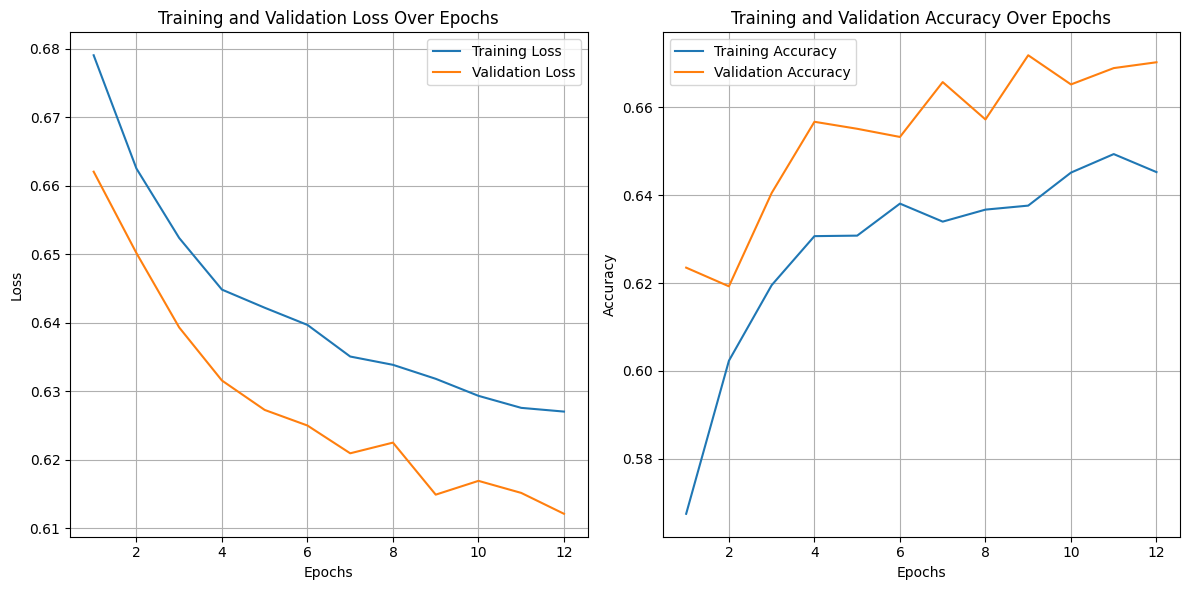

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_g) + 1), train_losses_g, label='Training Loss')
plt.plot(range(1, len(val_losses_g) + 1), val_losses_g, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies_g) + 1), train_accuracies_g, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies_g) + 1), val_accuracies_g, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
googlenet.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = googlenet(images).squeeze()
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    final_train_acc_g = correct / total
    print("Training accuracy:", final_train_acc_g * 100)

    correct, total = 0, 0
    all_preds_g = []
    all_labels_g = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = googlenet(images).squeeze()
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds_g.extend(predicted.cpu().numpy().reshape(-1).tolist())
        all_labels_g.extend(labels.cpu().numpy().reshape(-1).tolist())
    test_acc_g = correct / total
    print("Test accuracy:", test_acc_g * 100)


Training accuracy: 66.77305368745013
Test accuracy: 67.03004520074448


In the case of this model, the overall accuracy of the model decreases if compared to the 10K dataset. However, it can be seen from the confusion matrix below that with more balanced datasets we are able to classify the images with diabetic rethinopathy more effectively.

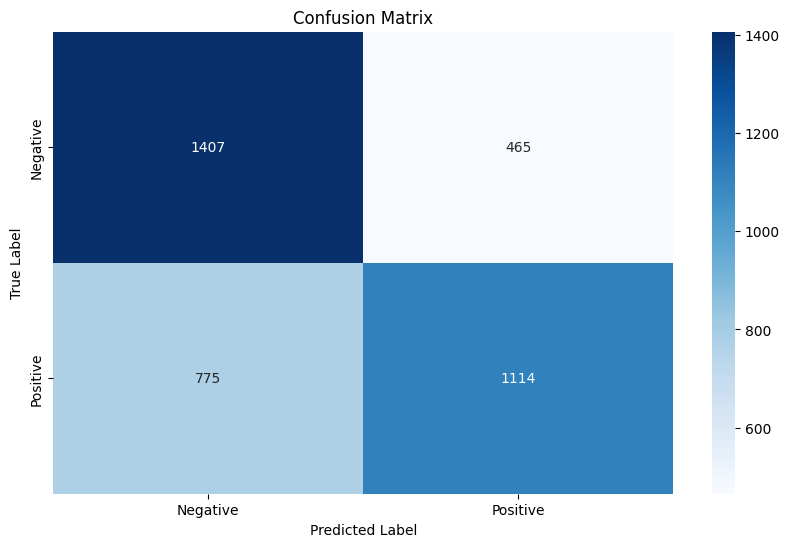

In [ ]:
cm_g = confusion_matrix(all_labels_g, all_preds_g)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_g, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_save_path = '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/google_binary_classification.pth'
torch.save(googlenet.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/google_binary_classification.pth


# **10. GoogleLeNet - 5 Classes**


In this section, we employ a pre-trained GoogleLeNet model for a multiclass classification task with five classes. The model's final fully connected layer is replaced with a custom classifier head, consisting of two linear layers separated by ReLU activation and dropout for regularization, followed by a softmax activation to output class probabilities.

In [ ]:
googlenet = models.googlenet(pretrained=True)
for param in googlenet.parameters():
    param.requires_grad = False

googlenet.fc = nn.Sequential(
    nn.Linear(googlenet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5),
    nn.Softmax(dim=1)
)

googlenet = googlenet.to(device)

criterion_g_5 = nn.CrossEntropyLoss()
optimizer_g_5 = optim.SGD(googlenet.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler_g_5 = ReduceLROnPlateau(optimizer_g_5, mode='min', factor=0.1, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


We iterated over the dataset for 12 epochs, adjusting model parameters based on backpropagation. Doing so, we monitored training and validation loss and accuracy, implementing early stopping to prevent overfitting. The results are visualized through loss curves, ensuring effective training for the ML project.

Epoch 1, Loss: 1.4947717620806562, Accuracy: 0.498803146016186
Validation Loss: 1.429789726736063, Accuracy: 0.4977399627758575
Epoch 2, Loss: 1.4132291462162425, Accuracy: 0.5047304228884076
Validation Loss: 1.4133321934638903, Accuracy: 0.4977399627758575
Epoch 3, Loss: 1.4056223887042745, Accuracy: 0.5047304228884076
Validation Loss: 1.4103274387236893, Accuracy: 0.4977399627758575
Epoch 4, Loss: 1.4035009594011454, Accuracy: 0.5047304228884076
Validation Loss: 1.4091902792818272, Accuracy: 0.4977399627758575
Epoch 5, Loss: 1.402423952007109, Accuracy: 0.5047304228884076
Validation Loss: 1.4087331638282932, Accuracy: 0.4977399627758575
Epoch 6, Loss: 1.4018710685077964, Accuracy: 0.5047304228884076
Validation Loss: 1.4083941261110962, Accuracy: 0.4977399627758575
Epoch 7, Loss: 1.4015716545315218, Accuracy: 0.5047304228884076
Validation Loss: 1.4080422652969016, Accuracy: 0.4977399627758575
Epoch 8, Loss: 1.401280207806814, Accuracy: 0.5047304228884076
Validation Loss: 1.40794886283

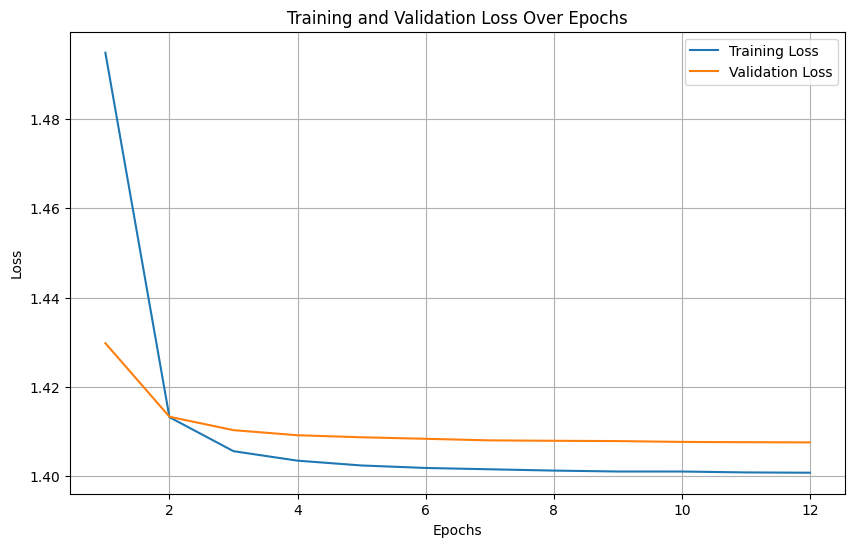

In [ ]:
patience_g_5 = 3
early_stopping_counter_g_5 = 0
previous_val_loss_g_5 = float('inf')

train_losses_g_5 = []
val_losses_g_5 = []
train_accuracies_g_5 = []
val_accuracies_g_5 = []

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels.data)
    return corrects.double() / labels.size(0)

for epoch in range(12):
    googlenet.train()
    running_loss_g_5 = 0.0
    running_corrects_g_5 = 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        optimizer_g_5.zero_grad()
        outputs = googlenet(images)
        loss = criterion_g_5(outputs, labels)
        loss.backward()
        optimizer_g_5.step()
        running_loss_g_5 += loss.item() * images.size(0)
        running_corrects_g_5 += torch.sum(torch.max(outputs, 1)[1] == labels.data)

    train_loss_g_5 = running_loss_g_5 / len(train_loader_5.dataset)
    train_accuracy_5 = running_corrects_g_5.double() / len(train_loader_5.dataset)
    train_losses_5.append(train_loss_g_5)
    train_accuracies_g_5.append(train_accuracy_g_5)
    print(f"Epoch {epoch+1}, Loss: {train_loss_g_5}, Accuracy: {train_accuracy_g_5}")

    googlenet.eval()
    val_loss_g_5 = 0.0
    val_corrects_g_5 = 0
    with torch.no_grad():
        for images, labels in test_loader_5:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion_g_5(outputs, labels)
            val_loss_g_5 += loss.item() * images.size(0)
            val_corrects_g_5 += torch.sum(torch.max(outputs, 1)[1] == labels.data)

    val_loss_g_5 /= len(test_loader_5.dataset)
    val_accuracy_g_5 = val_corrects_g_5.double() / len(test_loader_5.dataset)
    val_losses_g_5.append(val_loss_g_5)
    val_accuracies_g_5.append(val_accuracy_g_5)
    print(f"Validation Loss: {val_loss_g_5}, Accuracy: {val_accuracy_g_5}")

    scheduler_g_5.step(val_loss_g_5)

    if val_loss_g_5 < previous_val_loss_g_5:
        previous_val_loss_g_5 = val_loss_g_5
        early_stopping_counter_g_5 = 0
    else:
        early_stopping_counter_g_5 += 1
        if early_stopping_counter_g_5 >= patience_g_5:
            print("Early stopping triggered")
            break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_g_5) + 1), train_losses_g_5, label='Training Loss')
plt.plot(range(1, len(val_losses_g_5) + 1), val_losses_g_5, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

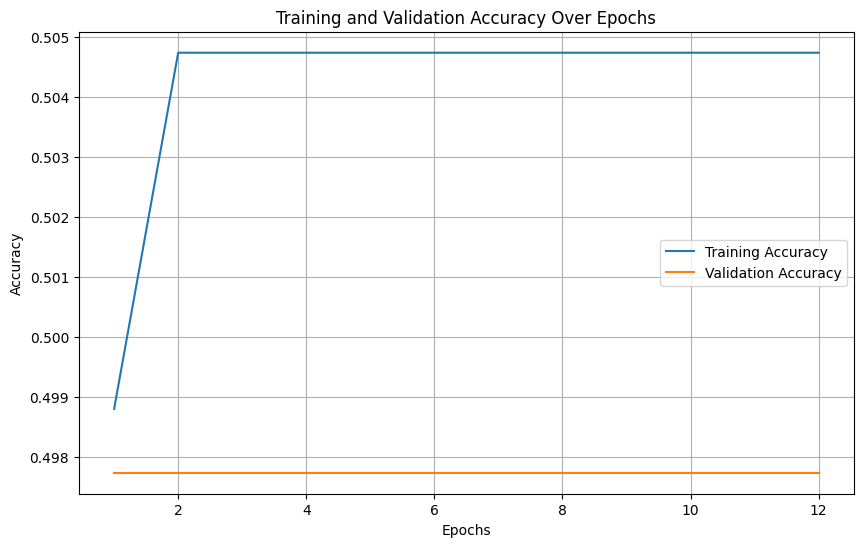

In [ ]:
train_accuracies_g_5 = [acc.cpu().numpy() for acc in train_accuracies_g_5]
val_accuracies_g_5 = [acc.cpu().numpy() for acc in val_accuracies_g_5]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies_g_5) + 1), train_accuracies_g_5, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies_g_5) + 1), val_accuracies_g_5, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

As can be seen in the image above, the plot displays constant accuracy values, indicating that the model's performance did not improve significantly during training.

This can be also seen in the following confusion matrix, in which is clear that the model classifies all images as 0. Since this dataset was unbalanced for the 5 classes, the problem could be still class imbalance. We therefore need to test the model on a more balanced dataset for the 5 classes.

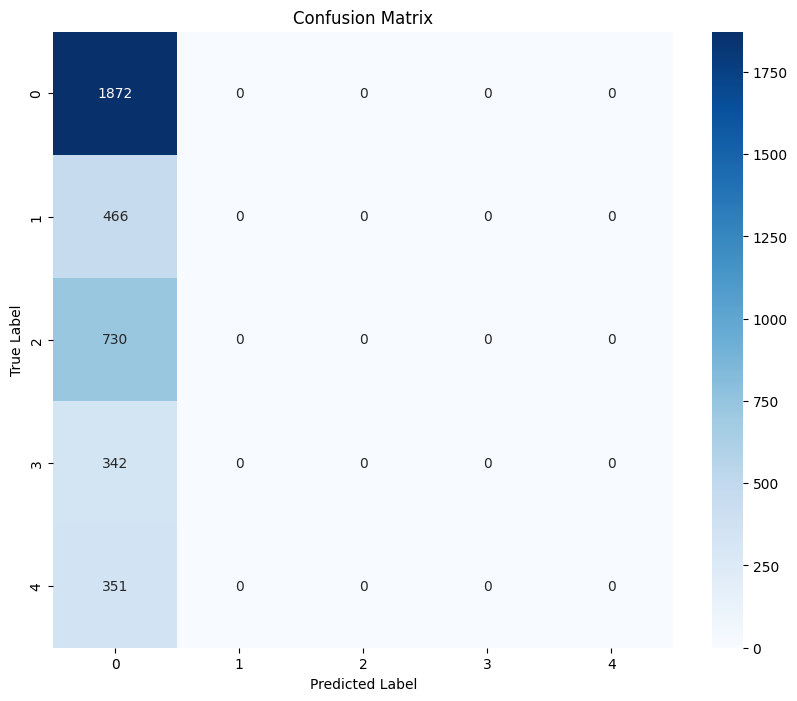

In [ ]:
all_preds_g_5 = []
all_labels_g_5 = []

with torch.no_grad():
    for images, labels in test_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet(images)
        _, preds = torch.max(outputs, 1)
        all_preds_g_5.extend(preds.cpu().numpy())
        all_labels_g_5.extend(labels.cpu().numpy())
cm_g_5 = confusion_matrix(all_labels_g_5, all_preds_g_5)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **11. ResNet - Binary Classification**

In this section, we employ yet another pre-trained ResnNet model to perform binary classification. ResNet, short for Residual Networks, is a deep learning architecture.
It leverages the concept of residual learning, which allows the network to learn residual functions with reference to the layer inputs, instead of learning unreferenced functions. This is achieved through the use of shortcut connections, or skip connections, which bypass one or more layers.


In [ ]:
def build_and_compile_model2(input_shape, num_classes):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output_layer)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    return model

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

def create_dataframe(df, source_folder):
    df['image_path'] = df['image'].map(lambda x: os.path.join(source_folder, f"{x}.jpeg"))
    return df

def data_generator(df, batch_size, num_classes):
    #datagen = ImageDataGenerator()
    while True:
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]

            images = []
            labels = []
            for _, row in batch_df.iterrows():
                img_path = row['image_path']
                if os.path.exists(img_path):
                    img = preprocess_image(img_path)
                    images.append(img)
                    label = tf.keras.utils.to_categorical(row['binary_level'], num_classes)
                    labels.append(label)

            if len(images) > 0:
                yield np.array(images), np.array(labels)

def count_elements(df, val):
    count = df['binary_level'].value_counts().loc[[val]].get(val, 0)
    return count

The function _build_and_compile_model_ constructs a convolutional neural network (CNN) using the ResNet50 architecture as the base model. This base model is pre-trained on the ImageNet dataset and does not include the top layers.

*   ResNet50 as Base Model: The base model is initialized with weights from the ImageNet dataset. The top layers are excluded (include_top=False) to allow for customization.
*   Additional Layers: Batch normalization, ReLU activation, global average pooling, and dropout are added to enhance performance and prevent overfitting.
*   Output Layer: A dense layer with a softmax activation function is added to classify the input into num_classes categories.
*   Model Compilation: The model is compiled with categorical cross entropy loss, the Adam optimizer, and accuracy as the evaluation metric.





The function _preprocess_image_ reads an image from a given path, resizes it to 224x224 pixels, which is the input size expected from ResNet, and normalizes the pixel values.

The function _create_dataframe_ adds a new column to the DataFrame, which contains the full paths to the images.

Mapping Image Paths: The image column in the DataFrame is mapped to create full image paths by concatenating with the source folder and adding the file extension.

The function _data_generator_ creates a generator that yields batches of images and their corresponding labels for training or evaluation.

*   Infinite Loop: The generator runs indefinitely, yielding batches of data.
*   Batch Processing: The DataFrame is processed in chunks of batch_size.
*   Image and Label Arrays: For each batch, images are preprocessed and labels are converted to one-hot encoding.
*   Yielding Batches: Non-empty batches of images and labels are yielded as NumPy arrays.


The function _count_elements_ returns the count of a specific value in the level column of the DataFrame.

* Value Counts: The function utilizes value_counts() to count occurrences of each value in the level column.
* Specific Value Count: It retrieves the count for the specified value val, returning 0 if the value is not present.

In [ ]:
if __name__ == '__main__':
    print("Starting the program...")
    print("Creating the model...")
    model = build_and_compile_model((224, 224, 3), 2)

    source_folder = '/content/drive/MyDrive/ML_project/DATA_UNZIPPED/balanced_extracted'
    df = pd.read_csv('/content/drive/MyDrive/ML_project/DATA_UNZIPPED/testLabels.csv')

    df['binary_level'] = df['level'].apply(lambda x: 1 if x > 0 else 0)

    df = create_dataframe(df, source_folder)

    df_train_val, df_test = train_test_split(df, test_size=0.15, random_state=42)
    df_train, df_valid = train_test_split(df_train_val, test_size=0.05, random_state=42)

    batch_size = 32

    train_generator = data_generator(df_train, batch_size, 2)
    valid_generator = data_generator(df_valid, batch_size, 2)
    test_generator = data_generator(df_test, batch_size, 2)

    steps_per_epoch = len(df_train) // batch_size
    validation_steps = len(df_valid) // batch_size
    test_steps = len(df_test) // batch_size

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint("model_eye.keras", verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, verbose=1)
    csv_log = CSVLogger("log.csv", append=True)

    callbacks = [early_stopping, checkpoint, reduce_lr, csv_log]

    print("Training the model...")
    history = model.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=valid_generator,
                        validation_steps=validation_steps,
                        epochs=10,
                        callbacks=callbacks)

    save_dir = '/content/drive/MyDrive/ML_project/DATA_UNZIPPED/MODELS'
    os.makedirs(save_dir, exist_ok=True)

    print("Saving the final model...")
    model_path = os.path.join(save_dir, "ResNet_model_binary.keras")
    model.save(model_path)
    print(f"Model saved to: {model_path}")

    print("Evaluating the model on test data...")
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')

Starting the program...
Creating the model...
Training the model...
Epoch 1/10
1351/1351 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.4958
Epoch 1: val_loss improved from inf to 0.94246, saving model to model_eye.keras
1351/1351 [==============================] - 816s 591ms/step - loss: 0.7422 - accuracy: 0.4958 - val_loss: 0.9425 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 2/10
1351/1351 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.5027
Epoch 2: val_loss improved from 0.94246 to 0.71431, saving model to model_eye.keras
1351/1351 [==============================] - 795s 588ms/step - loss: 0.7299 - accuracy: 0.5027 - val_loss: 0.7143 - val_accuracy: 0.4590 - lr: 0.0010
Epoch 3/10
1351/1351 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.5047
Epoch 3: val_loss did not improve from 0.71431
1351/1351 [==============================] - 790s 584ms/step - loss: 0.7395 - accuracy: 0.5047 - val_loss: 0.8165 - val_accurac

The data is split into training, validation, and test sets. Data generators are defined to yield batches of images and labels for these sets, with batch size set to 32.

Fine-tuning of the model involves several callbacks designed to optimize training: EarlyStopping halts training if validation loss does not improve for 10 epochs and restores the best weights; ModelCheckpoint saves the best observed model during training; ReduceLROnPlateau decreases the learning rate if validation loss plateaus, preventing the model from getting stuck in local minima; and CSVLogger records training metrics to a CSV file. The model is then trained using these configurations.

After training, the final model is evaluated on the test data, and the test loss and accuracy are computed and printed.

Despite the fine tuning approach the model has limited predictive power on the both train and test sets, with accuracy hovering around chance
levels, as well as a slight overfitting.






# **12. ResNet - 5 Classes**

The same approach is taken to perform quinary classification.


Here the previous binary model is adapted to perform classification over 5 target labels.

In [ ]:
def build_and_compile_model(input_shape, num_classes):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output_layer)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    return model

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

def create_dataframe(df, source_folder):
    df['image_path'] = df['image'].map(lambda x: os.path.join(source_folder, f"{x}.jpeg"))
    return df

def data_generator(df, batch_size, num_classes):
    #datagen = ImageDataGenerator()
    while True:
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]

            images = []
            labels = []
            for _, row in batch_df.iterrows():
                img_path = row['image_path']
                if os.path.exists(img_path):
                    img = preprocess_image(img_path)
                    images.append(img)
                    label = tf.keras.utils.to_categorical(row['level'], num_classes)
                    labels.append(label)

            if len(images) > 0:
                yield np.array(images), np.array(labels)

def count_elements(df, val):
    count = df['level'].value_counts().loc[[val]].get(val, 0)
    return count

In [ ]:
if __name__ == '__main__':
    print("Starting the program...")
    print("Creating the model...")
    model = build_and_compile_model((224, 224, 3), 5)

    source_folder = '/content/drive/MyDrive/ML_project/DATA_UNZIPPED/DATA_12K'
    df = pd.read_csv('/content/drive/MyDrive/ML_project/DATA_UNZIPPED/testLabels.csv')

    df = create_dataframe(df, source_folder)

    df_train_val, df_test = train_test_split(df, test_size=0.15, random_state=42)
    df_train, df_valid = train_test_split(df_train_val, test_size=0.05, random_state=42)

    batch_size = 32

    train_generator = data_generator(df_train, batch_size, 5)
    valid_generator = data_generator(df_valid, batch_size, 5)
    test_generator = data_generator(df_test, batch_size, 5)

    steps_per_epoch = len(df_train) // batch_size
    validation_steps = len(df_valid) // batch_size
    test_steps = len(df_test) // batch_size

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint("model_eye.keras", verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, verbose=1)
    csv_log = CSVLogger("log.csv", append=True)

    callbacks = [early_stopping, checkpoint, reduce_lr, csv_log]

    print("Training the model...")
    history = model.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=valid_generator,
                        validation_steps=validation_steps,
                        epochs=20,
                        callbacks=callbacks)

    save_dir = '/content/drive/MyDrive/ML_project/DATA_UNZIPPED'
    os.makedirs(save_dir, exist_ok=True)

    print("Saving the final model...")
    model_path = os.path.join(save_dir, "ResNet_model.keras")
    model.save(model_path)
    print(f"Model saved to: {model_path}")

    print("Evaluating the model on test data...")
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')

Starting the program...
Creating the model...
94765736/94765736 [==============================] - 0s 0us/step
Training the model...
Epoch 1/20
1351/1351 [==============================] - ETA: 0s - loss: 1.3946 - accuracy: 0.4932
Epoch 1: val_loss improved from inf to 1.59844, saving model to model_eye.keras
1351/1351 [==============================] - 3010s 2s/step - loss: 1.3946 - accuracy: 0.4932 - val_loss: 1.5984 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 2/20
1351/1351 [==============================] - ETA: 0s - loss: 1.4147 - accuracy: 0.4930
Epoch 2: val_loss improved from 1.59844 to 1.48299, saving model to model_eye.keras
1351/1351 [==============================] - 781s 578ms/step - loss: 1.4147 - accuracy: 0.4930 - val_loss: 1.4830 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 3/20
1351/1351 [==============================] - ETA: 0s - loss: 1.3748 - accuracy: 0.4992
Epoch 3: val_loss did not improve from 1.48299
1351/1351 [==============================] - 782s 579ms/step - l

1/1 [==============================] - 0s 249ms/step


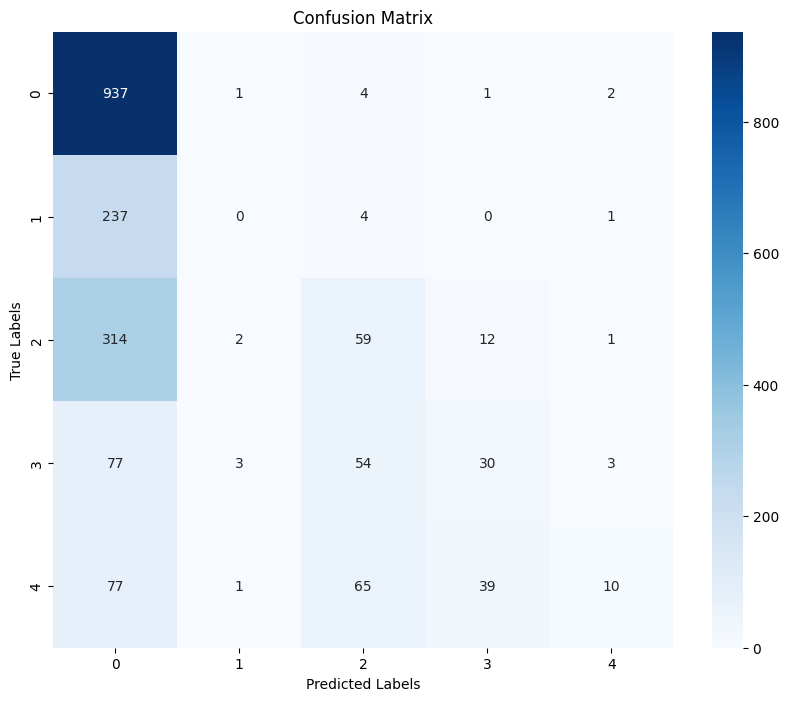

'              precision    recall  f1-score   support\n\n           0       0.57      0.99      0.72       945\n           1       0.00      0.00      0.00       242\n           2       0.32      0.15      0.21       388\n           3       0.37      0.18      0.24       167\n           4       0.59      0.05      0.10       192\n\n    accuracy                           0.54      1934\n   macro avg       0.37      0.28      0.25      1934\nweighted avg       0.43      0.54      0.43      1934\n'

In [ ]:
def get_test_labels_and_predictions(test_generator, num_steps):
    true_labels = []
    predictions = []

    for _ in range(num_steps):
        x, y = next(test_generator)
        preds = model.predict(x)
        true_labels.extend(np.argmax(y, axis=1))
        predictions.extend(np.argmax(preds, axis=1))

    return np.array(true_labels), np.array(predictions)


true_labels, predictions = get_test_labels_and_predictions(test_generator, test_steps)
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

classification_report(true_labels, predictions, target_names=[str(i) for i in range(5)])

While a slight improvement can be seen compared to the binary classification, the model’s performance on both the validation and test is still only slightly better than random chance. Moreover, while healthy retinas are correctly classified in most cases, the model seems to struggle with the other classes, s can be seen from the confusion matrix above.

# **13. Random Model - Binary Classification**

In this section, we performed binary classification using a random model.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

num_classes = 2

correct_random_train = 0
total_random_train = 0
for images, labels in train_loader:
    batch_size = labels.size(0)
    random_outputs = torch.rand(batch_size, num_classes)
    _, predicted = torch.max(random_outputs, 1)
    total_random_train += labels.size(0)
    correct_random_train += (predicted == labels).sum().item()

train_acc_random = correct_random_train / total_random_train
print("Random model training accuracy:", train_acc_random * 100)

correct_random_test = 0
total_random_test = 0
all_preds_random = []
all_labels_random = []
for images, labels in test_loader:
    batch_size = labels.size(0)
    random_outputs = torch.rand(batch_size, num_classes)
    _, predicted = torch.max(random_outputs, 1)
    total_random_test += labels.size(0)
    correct_random_test += (predicted == labels).sum().item()
    all_preds_random.extend(predicted.cpu().numpy())
    all_labels_random.extend(labels.cpu().numpy())

test_acc_random = correct_random_test / total_random_test
print("Random model test accuracy:", test_acc_random * 100)

Random model training accuracy: 49.49276188305027
Random model test accuracy: 48.97633608082957


The comparative analysis shows that the pre-trained models for binary classification, despite their flaws, perform better than this random model.

The trained models demonstrate better learning, higher accuracy, and less randomness.

# **14. Random Model - 5 Classes**


In this section, we performed 5 class classificationses classification using a random model.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

num_classes = 5

correct_random_train = 0
total_random_train = 0
for images, labels in train_loader_5:
    batch_size = labels.size(0)
    random_outputs = torch.rand(batch_size, num_classes)
    _, predicted = torch.max(random_outputs, 1)
    total_random_train += labels.size(0)
    correct_random_train += (predicted == labels).sum().item()

train_acc_random = correct_random_train / total_random_train
print("Random model training accuracy:", train_acc_random * 100)

correct_random_test = 0
total_random_test = 0
all_preds_random = []
all_labels_random = []
for images, labels in test_loader_5:
    batch_size = labels.size(0)
    random_outputs = torch.rand(batch_size, num_classes)
    _, predicted = torch.max(random_outputs, 1)
    total_random_test += labels.size(0)
    correct_random_test += (predicted == labels).sum().item()
    all_preds_random.extend(predicted.cpu().numpy())
    all_labels_random.extend(labels.cpu().numpy())

test_acc_random = correct_random_test / total_random_test
print("Random model test accuracy:", test_acc_random * 100)

Random model training accuracy: 19.810783084463697
Random model test accuracy: 20.12762563148099


The comparative analysis shows that the pre-trained models for 5 class classification, despite their flaws, perform significantly better than this random model.

The trained models demonstrate better learning, higher accuracy, and less randomness.

# **15. Kolmogorov-Arnolds Network (KAN)**

As explained in more details in our report, we tried to use a newly proposed architecture, relying on the Kolmogorov-Arnolds representation theorem, to build a simple convolutional network for our classification task. The network we built consists of two KAN convolutional layers and a KAN linear layer. The model has been trained only on the 12,000 images dataset for the quinary classification. After a total of 10 epochs, it achieved an accuracy of 49.77% and a loss of 1.37. However, all the images in the test set were classified as 0, suggesting that either our network is not deep enough or the dataset we are using for training is not large enough. Moreover, this new type of neural network is still to be optimize,as pointed out by the authors themselves, so it is very computationally expensive. For all of these reasons, we didn't try to train more complex KAN models.

In [ ]:
from KANConv import KAN_Convolutional_Layer
from KANLinear import KANLinear

class KKAN_Convolutional_Network(nn.Module):
    def __init__(self, device: str = 'cpu'):
        super().__init__()

        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(5, 5),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(5, 5),
            device=device
        )

        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.kan1 = KANLinear(
            in_features=  279075,
            out_features= 5,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1],
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = x.flatten(start_dim=1)
        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [ ]:
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    with tqdm(enumerate(train_loader_5), total=len(train_loader_5), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
        for batch_idx, (images, labels) in pbar:
            images, labels = images.to('cpu'), labels.to('cpu')

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            current_train_accuracy = 100 * correct / total
            if batch_idx % 100 == 0:
                pbar.set_postfix({
                    'Loss': f"{loss.item():.4f}",
                    'Acc': f"{current_train_accuracy:.2f}%"
                })

    train_accuracy = 100. * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader_5):.4f}, Train Accuracy: {train_accuracy:.2f}%")

In [ ]:
from sklearn.metrics import classification_report

with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_predicted = []
    for images, labels in test_loader_5:

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss/total:.4f}, Test Accuracy: {test_accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_predicted)
print(cm)

report = classification_report(all_labels, all_predicted)
print(report)

Test Loss: 1.3767, Test Accuracy: 49.77%
[[1872    0    0    0    0]
 [ 466    0    0    0    0]
 [ 730    0    0    0    0]
 [ 342    0    0    0    0]
 [ 351    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      1872
           1       0.00      0.00      0.00       466
           2       0.00      0.00      0.00       730
           3       0.00      0.00      0.00       342
           4       0.00      0.00      0.00       351

    accuracy                           0.50      3761
   macro avg       0.10      0.20      0.13      3761
weighted avg       0.25      0.50      0.33      3761



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **16. Ensembling - Binary Classification**

Next, we perform ensembling to improve the accuracy and robustness of models by combining predictions from multiple of them. We use the models trained for binary classification as we mainly aim to improve it in this balanced dataset.

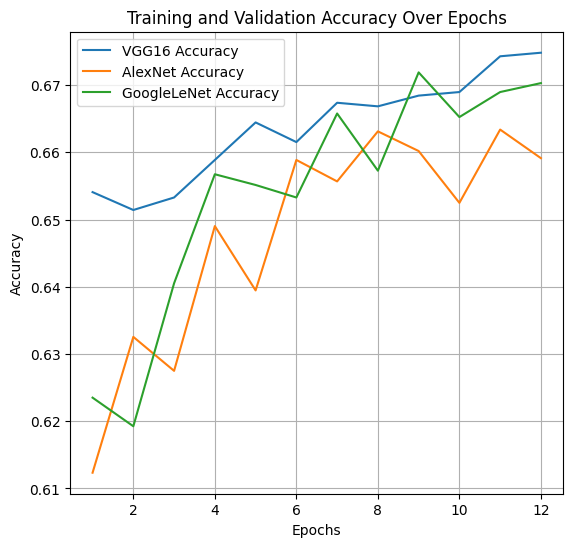

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='VGG16 Accuracy')
plt.plot(range(1, len(test_accuracies_a) + 1), test_accuracies_a, label='AlexNet Accuracy')
plt.plot(range(1, len(val_accuracies_g) + 1), val_accuracies_g, label='GoogleLeNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

The figure illustrates the training and validation accuracy over epochs for three different deep learning models: VGG16, AlexNet, and GoogleLeNet.

This indicates that all three models improve their accuracy over time, with VGG16 showing the highest final accuracy. This comparative analysis highlights the performance trends and stability of each model during the training process.

In [ ]:
googlenet.load_state_dict(torch.load('/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/google_binary_classification.pth'))
googlenet.to(device)
googlenet.eval()

alexnet.load_state_dict(torch.load('/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/alex_binary_classification.pth'))
alexnet.to(device)
alexnet.eval()

vgg16.load_state_dict(torch.load('/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/vgg16_binary_classification.pth'))
vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

vgg_preds = []
alexnet_preds = []
googlenet_preds = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)

        outputs_v = vgg16(images)
        preds_v = torch.sigmoid(outputs_v).cpu().numpy()
        vgg_preds.append(preds_v)

        outputs_a = alexnet(images)
        preds_a = torch.sigmoid(outputs_a).cpu().numpy()
        alexnet_preds.append(preds_a)

        outputs_g = googlenet(images)
        preds_g = torch.sigmoid(outputs_g).cpu().numpy()
        googlenet_preds.append(preds_g)

vgg_preds = np.concatenate(vgg_preds, axis=0)
alexnet_preds = np.concatenate(alexnet_preds, axis=0)
googlenet_preds = np.concatenate(googlenet_preds, axis=0)


In [ ]:
ensemble_preds = (googlenet_preds + alexnet_preds + vgg_preds) / 3.0


In [ ]:
ensemble_preds = (ensemble_preds > 0.5).astype(int)
true_labels = test_dataset.labels

ensemble_accuracy = accuracy_score(true_labels, ensemble_preds)
print(f'Ensemble Accuracy: {ensemble_accuracy:.4f}')

Ensemble Accuracy: 0.6791


The ensemble accuracy is satisfactory and it's the highest one so far for the binary classification, making this our best model. As can be seen from the confusion matrix, we get improved classification.

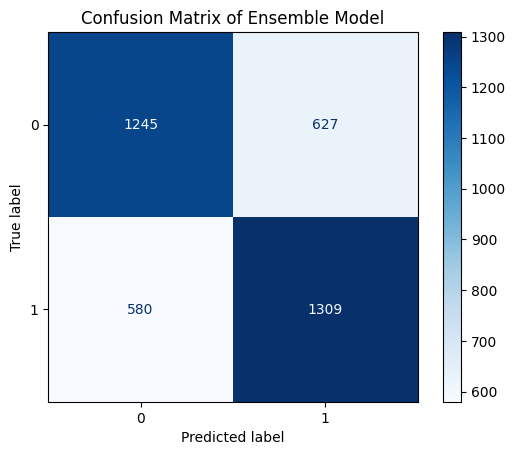

In [ ]:
cm = confusion_matrix(true_labels, ensemble_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Ensemble Model')
plt.show()